In [1]:
%%time
!pip install torch torchvision --quiet

import os
import time
import json
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm


start_time = time.time()

config = {
    "paths": {
        "train": "/kaggle/input/pytorch-challange-flower-dataset/dataset/train",
        "valid": "/kaggle/input/pytorch-challange-flower-dataset/dataset/valid",
        "test": "/kaggle/input/pytorch-challange-flower-dataset/dataset/test",
        "cat_to_name": "/kaggle/input/pytorch-challange-flower-dataset/cat_to_name.json",
        "submission": "submission.csv"
    },
    "training": {
        "batch_size": 32,  # Changed from 64
        "epochs": 25,      # Changed from 15
        "lr": 0.0003,      # Changed from 0.001
        "grid_size": 3,
        "weight_decay": 0.001  # Added
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Load class mapping
with open(config['paths']['cat_to_name']) as f:
    cat_to_name = json.load(f)

print(f"Setup completed in {time.time()-start_time:.2f}s")
print(f"Using device: {config['device'].upper()}")


print("\n\033[1m[2/6] Preparing datasets...\033[0m")
start_time = time.time()

# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

eval_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_data = datasets.ImageFolder(config['paths']['train'], transform=train_transforms)
valid_data = datasets.ImageFolder(config['paths']['valid'], transform=eval_transforms)

# Create dataloaders
train_loader = DataLoader(train_data, batch_size=config['training']['batch_size'], 
                         shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=config['training']['batch_size'],
                        shuffle=False, num_workers=2)

print(f"Dataset preparation completed in {time.time()-start_time:.2f}s")
print(f"Training samples: {len(train_data)} | Validation samples: {len(valid_data)}")


start_time = time.time()

class GlobalFeatureModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = models.resnet50(pretrained=True)
        self.base.fc = nn.Identity()  # Remove final FC layer
        
    def forward(self, x):
        return self.base(x)

class GridFeatureModel(nn.Module):
    def __init__(self, grid_size=3):
        super().__init__()
        self.grid_size = grid_size
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Identity()
        
        # Modified classifier (direct to 102 classes)
        self.classifier = nn.Sequential(
            nn.Linear(2048 * grid_size**2, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 102)  # Changed final layer to 102
        )

    def split_grids(self, x):
        B, C, H, W = x.shape
        gh, gw = H//self.grid_size, W//self.grid_size
        grids = x.unfold(2, gh, gh).unfold(3, gw, gw)
        grids = grids.contiguous().view(B, C, self.grid_size**2, gh, gw)
        grids = grids.permute(0,2,1,3,4).reshape(-1, C, gh, gw)
        return grids

    def forward(self, x):
        grids = self.split_grids(x)
        features = self.base_model(grids)
        features = features.view(x.size(0), -1)  # [B, 2048*9]
        return self.classifier(features)  # Direct classification

# Initialize models
global_model = GlobalFeatureModel().to(config['device'])
grid_model = GridFeatureModel(grid_size=config['training']['grid_size']).to(config['device'])

# Classifiers
global_classifier = nn.Linear(2048, 102).to(config['device'])

# Optimizers
global_optim = torch.optim.Adam(global_classifier.parameters(), lr=config['training']['lr'])
grid_optim = torch.optim.AdamW(
    grid_model.parameters(),  # ✅ CORRECT (classifier is part of model)
    lr=config['training']['lr'],
    weight_decay=config['training']['weight_decay']
)

grid_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    grid_optim,
    mode='max',
    factor=0.5,
    patience=2,
    verbose=True
)

criterion = nn.CrossEntropyLoss()

print(f"Model initialization completed in {time.time()-start_time:.2f}s")
print(f"Global model parameters: {sum(p.numel() for p in global_model.parameters())}")


def validate_model(model, name):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad(), tqdm(valid_loader, unit="batch", desc=f"{name} Validation") as pbar:
        for inputs, labels in pbar:
            inputs = inputs.to(config['device'])
            labels = labels.to(config['device'])
            
            if name == "Global":
                features = model(inputs)
                outputs = global_classifier(features)
            else:  # Grid model
                outputs = model(inputs)  # Direct output
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            pbar.set_postfix(acc=100.*correct/total)
    
    return 100. * correct / total

def train_global_model():
    best_acc = 0.0
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(config['training']['epochs']):
        global_model.train()
        global_classifier.train()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(train_loader, desc=f"Global Epoch {epoch+1}") as pbar:
            for inputs, labels in pbar:
                inputs = inputs.to(config['device'])
                labels = labels.to(config['device'])
                
                global_optim.zero_grad()
                with torch.cuda.amp.autocast():
                    features = global_model(inputs)
                    outputs = global_classifier(features)
                    loss = criterion(outputs, labels)
                
                scaler.scale(loss).backward()
                scaler.step(global_optim)
                scaler.update()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                pbar.set_postfix(loss=loss.item(), acc=100.*correct/total)
        
        val_acc = validate_model(global_model, "Global")
        
        print(f"Global Epoch {epoch+1} Summary:")
        print(f"Train Loss: {running_loss/len(train_loader):.4f} | "
              f"Train Acc: {100.*correct/total:.2f}% | "
              f"Val Acc: {val_acc:.2f}%")

def train_grid_model():
    best_acc = 0.0
    patience_counter = 0
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(config['training']['epochs']):
        grid_model.train()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(train_loader, desc=f"Grid Epoch {epoch+1}") as pbar:
            for inputs, labels in pbar:
                inputs = inputs.to(config['device'])
                labels = labels.to(config['device'])
                
                grid_optim.zero_grad()
                
                with torch.cuda.amp.autocast():
                    outputs = grid_model(inputs)
                    loss = criterion(outputs, labels)
                
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(grid_model.parameters(), 1.0)
                scaler.step(grid_optim)
                scaler.update()
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                pbar.set_postfix(loss=loss.item(), acc=100.*correct/total)
        
        val_acc = validate_model(grid_model, "Grid")
        grid_scheduler.step(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 3:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

        print(f"Grid Epoch {epoch+1} Summary:")
        print(f"Train Loss: {running_loss/len(train_loader):.4f} | "
              f"Train Acc: {100.*correct/total:.2f}% | "
              f"Val Acc: {val_acc:.2f}%")

# Train models
print("\n\033[1mTraining Global Model:\033[0m")
train_global_model()

print("\n\033[1mTraining Enhanced Grid Model:\033[0m")
train_grid_model()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.5 MB/s eta 0:00:00:00:0100:01

[1/6] Initializing setup...
Setup completed in 0.07s
Using device: CUDA

[2/6] Preparing datasets...
Dataset preparation completed in 16.62s
Training samples: 6552 | Validation samples: 818


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

Model initialization completed in 2.93s
Global model parameters: 23508032

[4/6] Starting training...

Training Global Model:


Global Validation: 100%|██████████| 26/26 [00:06<00:00,  4.05batch/s, acc=65.4]


Global Epoch 1 Summary:
Train Loss: 3.4221 | Train Acc: 33.52% | Val Acc: 65.40%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.67batch/s, acc=83.5]


Global Epoch 2 Summary:
Train Loss: 1.8649 | Train Acc: 71.14% | Val Acc: 83.50%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.79batch/s, acc=89.1]


Global Epoch 3 Summary:
Train Loss: 1.2639 | Train Acc: 80.33% | Val Acc: 89.12%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.77batch/s, acc=90.7]


Global Epoch 4 Summary:
Train Loss: 0.9792 | Train Acc: 84.37% | Val Acc: 90.71%


Global Validation: 100%|██████████| 26/26 [00:04<00:00,  6.46batch/s, acc=91.2]


Global Epoch 5 Summary:
Train Loss: 0.8260 | Train Acc: 85.58% | Val Acc: 91.20%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.97batch/s, acc=91.6]


Global Epoch 6 Summary:
Train Loss: 0.6919 | Train Acc: 87.91% | Val Acc: 91.56%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.75batch/s, acc=92.9]


Global Epoch 7 Summary:
Train Loss: 0.6284 | Train Acc: 88.32% | Val Acc: 92.91%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.77batch/s, acc=93.4]


Global Epoch 8 Summary:
Train Loss: 0.5760 | Train Acc: 88.55% | Val Acc: 93.40%


Global Validation: 100%|██████████| 26/26 [00:04<00:00,  6.25batch/s, acc=93.6]


Global Epoch 9 Summary:
Train Loss: 0.5320 | Train Acc: 89.73% | Val Acc: 93.64%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.74batch/s, acc=93.3]


Global Epoch 10 Summary:
Train Loss: 0.4924 | Train Acc: 90.08% | Val Acc: 93.28%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.66batch/s, acc=93.5]


Global Epoch 11 Summary:
Train Loss: 0.4601 | Train Acc: 90.72% | Val Acc: 93.52%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.64batch/s, acc=93.6]


Global Epoch 12 Summary:
Train Loss: 0.4413 | Train Acc: 90.89% | Val Acc: 93.64%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.56batch/s, acc=93.6]


Global Epoch 13 Summary:
Train Loss: 0.4232 | Train Acc: 91.18% | Val Acc: 93.64%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.57batch/s, acc=93.5]


Global Epoch 14 Summary:
Train Loss: 0.4062 | Train Acc: 91.25% | Val Acc: 93.52%


Global Validation: 100%|██████████| 26/26 [00:04<00:00,  6.34batch/s, acc=93.6]


Global Epoch 15 Summary:
Train Loss: 0.4036 | Train Acc: 91.16% | Val Acc: 93.64%


Global Validation: 100%|██████████| 26/26 [00:04<00:00,  5.98batch/s, acc=94.4]


Global Epoch 16 Summary:
Train Loss: 0.3835 | Train Acc: 91.24% | Val Acc: 94.38%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.70batch/s, acc=93.9]


Global Epoch 17 Summary:
Train Loss: 0.3700 | Train Acc: 91.73% | Val Acc: 93.89%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.83batch/s, acc=94]  


Global Epoch 18 Summary:
Train Loss: 0.3438 | Train Acc: 92.51% | Val Acc: 94.01%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.61batch/s, acc=94.7]


Global Epoch 19 Summary:
Train Loss: 0.3372 | Train Acc: 92.43% | Val Acc: 94.74%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.65batch/s, acc=94.6]


Global Epoch 20 Summary:
Train Loss: 0.3334 | Train Acc: 92.45% | Val Acc: 94.62%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.73batch/s, acc=93.9]


Global Epoch 21 Summary:
Train Loss: 0.3097 | Train Acc: 92.98% | Val Acc: 93.89%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.82batch/s, acc=95.2]


Global Epoch 22 Summary:
Train Loss: 0.3060 | Train Acc: 92.74% | Val Acc: 95.23%


Global Validation: 100%|██████████| 26/26 [00:04<00:00,  5.90batch/s, acc=94.7]


Global Epoch 23 Summary:
Train Loss: 0.3061 | Train Acc: 92.81% | Val Acc: 94.74%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.53batch/s, acc=93.9]


Global Epoch 24 Summary:
Train Loss: 0.2941 | Train Acc: 93.09% | Val Acc: 93.89%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.71batch/s, acc=93.9]
<timed exec>:218: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Global Epoch 25 Summary:
Train Loss: 0.2959 | Train Acc: 92.99% | Val Acc: 93.89%

Training Enhanced Grid Model:


Grid Validation: 100%|██████████| 26/26 [00:04<00:00,  5.72batch/s, acc=87.3]


Grid Epoch 1 Summary:
Train Loss: 2.2408 | Train Acc: 50.24% | Val Acc: 87.29%


Grid Validation: 100%|██████████| 26/26 [00:04<00:00,  6.44batch/s, acc=94.9]


Grid Epoch 2 Summary:
Train Loss: 0.7811 | Train Acc: 81.18% | Val Acc: 94.87%


Grid Validation: 100%|██████████| 26/26 [00:03<00:00,  6.53batch/s, acc=95.6]


Grid Epoch 3 Summary:
Train Loss: 0.5032 | Train Acc: 87.64% | Val Acc: 95.60%


Grid Validation: 100%|██████████| 26/26 [00:04<00:00,  6.39batch/s, acc=96.3]


Grid Epoch 4 Summary:
Train Loss: 0.4035 | Train Acc: 89.87% | Val Acc: 96.33%


Grid Validation: 100%|██████████| 26/26 [00:04<00:00,  6.22batch/s, acc=96.5]


Grid Epoch 5 Summary:
Train Loss: 0.3472 | Train Acc: 91.07% | Val Acc: 96.45%


Grid Validation: 100%|██████████| 26/26 [00:04<00:00,  6.39batch/s, acc=96.5]


Grid Epoch 6 Summary:
Train Loss: 0.3120 | Train Acc: 91.77% | Val Acc: 96.45%


Grid Validation: 100%|██████████| 26/26 [00:03<00:00,  6.57batch/s, acc=96.8]


Grid Epoch 7 Summary:
Train Loss: 0.2833 | Train Acc: 92.87% | Val Acc: 96.82%


Grid Validation: 100%|██████████| 26/26 [00:04<00:00,  6.17batch/s, acc=96.9]


Grid Epoch 8 Summary:
Train Loss: 0.2673 | Train Acc: 92.66% | Val Acc: 96.94%


Grid Validation: 100%|██████████| 26/26 [00:04<00:00,  6.12batch/s, acc=97.4]


Grid Epoch 9 Summary:
Train Loss: 0.2354 | Train Acc: 93.61% | Val Acc: 97.43%


Grid Validation: 100%|██████████| 26/26 [00:04<00:00,  6.21batch/s, acc=95.8]


Grid Epoch 10 Summary:
Train Loss: 0.2323 | Train Acc: 93.61% | Val Acc: 95.84%


Grid Validation: 100%|██████████| 26/26 [00:04<00:00,  6.32batch/s, acc=97.6]


Grid Epoch 11 Summary:
Train Loss: 0.1715 | Train Acc: 95.57% | Val Acc: 97.56%


Grid Validation: 100%|██████████| 26/26 [00:04<00:00,  6.44batch/s, acc=97.7]


Grid Epoch 12 Summary:
Train Loss: 0.1493 | Train Acc: 96.14% | Val Acc: 97.68%


Grid Validation: 100%|██████████| 26/26 [00:03<00:00,  6.69batch/s, acc=97.3]


Grid Epoch 13 Summary:
Train Loss: 0.1344 | Train Acc: 96.41% | Val Acc: 97.31%


Grid Validation: 100%|██████████| 26/26 [00:04<00:00,  6.13batch/s, acc=97.8]


Grid Epoch 14 Summary:
Train Loss: 0.1571 | Train Acc: 95.99% | Val Acc: 97.80%


Grid Validation: 100%|██████████| 26/26 [00:03<00:00,  6.90batch/s, acc=98.4]


Grid Epoch 15 Summary:
Train Loss: 0.1324 | Train Acc: 96.23% | Val Acc: 98.41%


Grid Validation: 100%|██████████| 26/26 [00:03<00:00,  6.63batch/s, acc=97.2]


Grid Epoch 16 Summary:
Train Loss: 0.1293 | Train Acc: 96.63% | Val Acc: 97.19%


Grid Validation: 100%|██████████| 26/26 [00:03<00:00,  7.02batch/s, acc=98]  


Grid Epoch 17 Summary:
Train Loss: 0.1267 | Train Acc: 96.75% | Val Acc: 98.04%


Global Validation: 100%|██████████| 26/26 [00:03<00:00,  6.97batch/s, acc=93.9]0.0184] 


- Global Model: 93.89%


Grid Validation: 100%|██████████| 26/26 [00:03<00:00,  6.56batch/s, acc=97.7]

- Grid Model: 97.68%
CPU times: user 30min 12s, sys: 1min 51s, total: 32min 4s
Wall time: 35min 16s


In [20]:
print("Final validation accuracies:")
print(f"- Global Model: {validate_model(global_model, 'Global'):.2f}%")
print(f"- Grid Model: {validate_model(grid_model, 'Grid'):.2f}%")

Final validation accuracies:


Global Validation: 100%|██████████| 26/26 [00:04<00:00,  6.19batch/s, acc=94.6]


- Global Model: 94.62%


Grid Validation: 100%|██████████| 26/26 [00:03<00:00,  6.59batch/s, acc=96.1]

- Grid Model: 96.09%


In [17]:
train_dataset = datasets.ImageFolder(config['paths']['train'])
id2label = {idx: class_name for class_name, idx in train_dataset.class_to_idx.items()}

def predict_corrected(model, image_path, id2label, cat_to_name):
    img = Image.open(image_path).convert('RGB')
    img = eval_transforms(img).unsqueeze(0).to(config['device'])
    
    with torch.no_grad():
        outputs = model(img)
    
    predicted_idx = outputs.argmax().item()
    folder_num = id2label[predicted_idx]
    flower_name = cat_to_name[folder_num]
    
    return flower_name

# Generate predictions
test_dir = config['paths']['test']
test_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

correct_submission = []
for img_path in tqdm(test_images, desc="Generating predictions"):
    correct_pred = predict_corrected(grid_model, img_path, id2label, cat_to_name)
    correct_submission.append([os.path.basename(img_path), correct_pred])

correct_df = pd.DataFrame(correct_submission, columns=['image_id', 'flower_name'])
correct_df.to_csv('submission_corrected.csv', index=False)


Generating predictions: 100%|██████████| 819/819 [00:13<00:00, 59.91it/s]


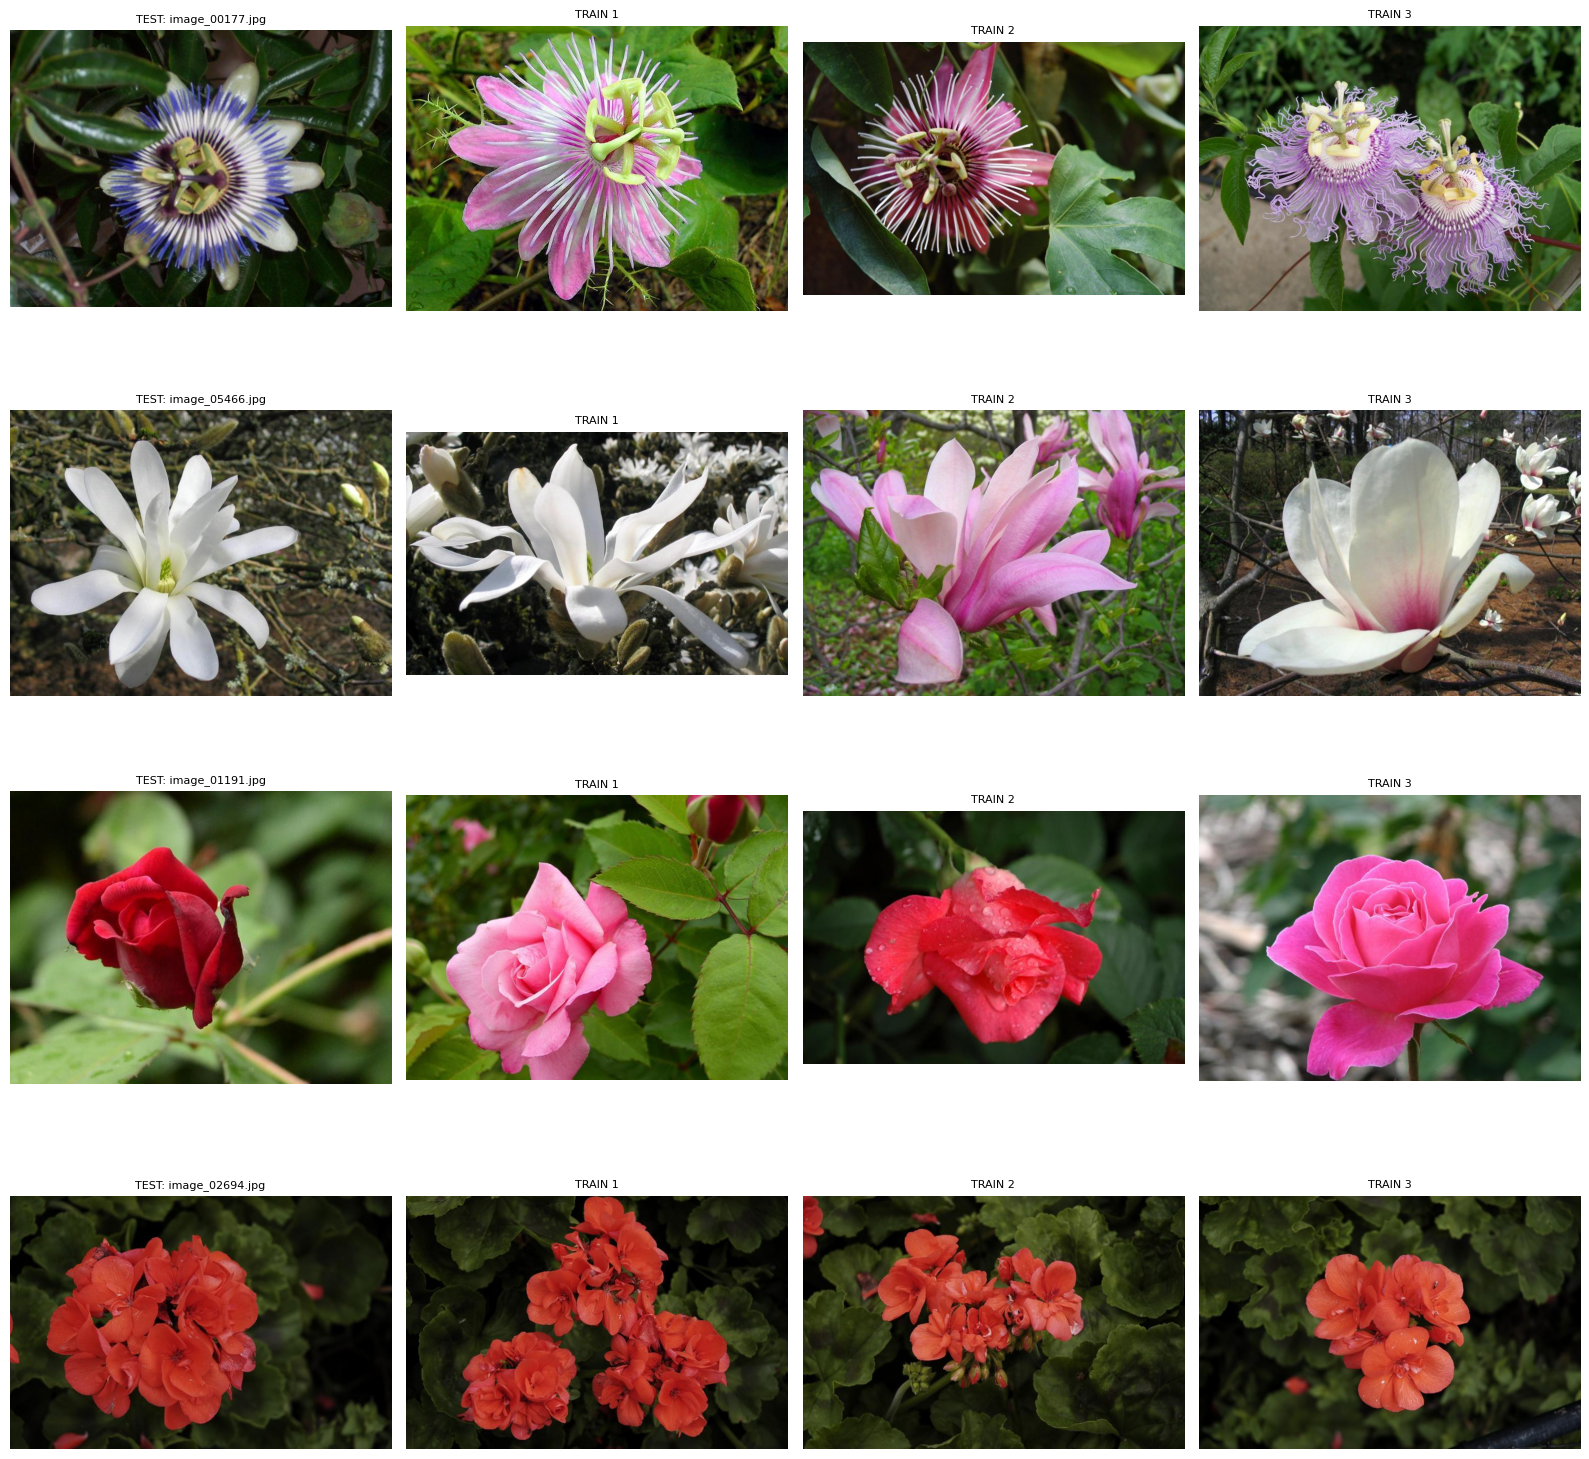

In [21]:
random_samples = correct_df.sample(n=4).reset_index(drop=True)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for idx, (_, row) in enumerate(random_samples.iterrows()):
    test_image_name = row['image_id']
    predicted_flower = row['flower_name']
    
    test_path = f'/kaggle/input/pytorch-challange-flower-dataset/dataset/test/{test_image_name}'
    test_img = Image.open(test_path)
    axes[idx, 0].imshow(test_img)
    axes[idx, 0].set_title(f'TEST: {test_image_name}', fontsize=8)
    axes[idx, 0].axis('off')
    
    name_to_cat = {v: k for k, v in cat_to_name.items()}
    category_num = name_to_cat[predicted_flower]
    train_dir = f'/kaggle/input/pytorch-challange-flower-dataset/dataset/train/{category_num}'
    train_images = [f for f in os.listdir(train_dir) if f.lower().endswith('.jpg')]
    selected_train = random.sample(train_images, min(3, len(train_images)))
    
    for train_idx, train_file in enumerate(selected_train):
        train_path = os.path.join(train_dir, train_file)
        train_img = Image.open(train_path)
        axes[idx, train_idx + 1].imshow(train_img)
        axes[idx, train_idx + 1].set_title(f'TRAIN {train_idx+1}', fontsize=8)
        axes[idx, train_idx + 1].axis('off')

plt.tight_layout()
plt.show()